In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


First 10 images from Train
*********************************** 



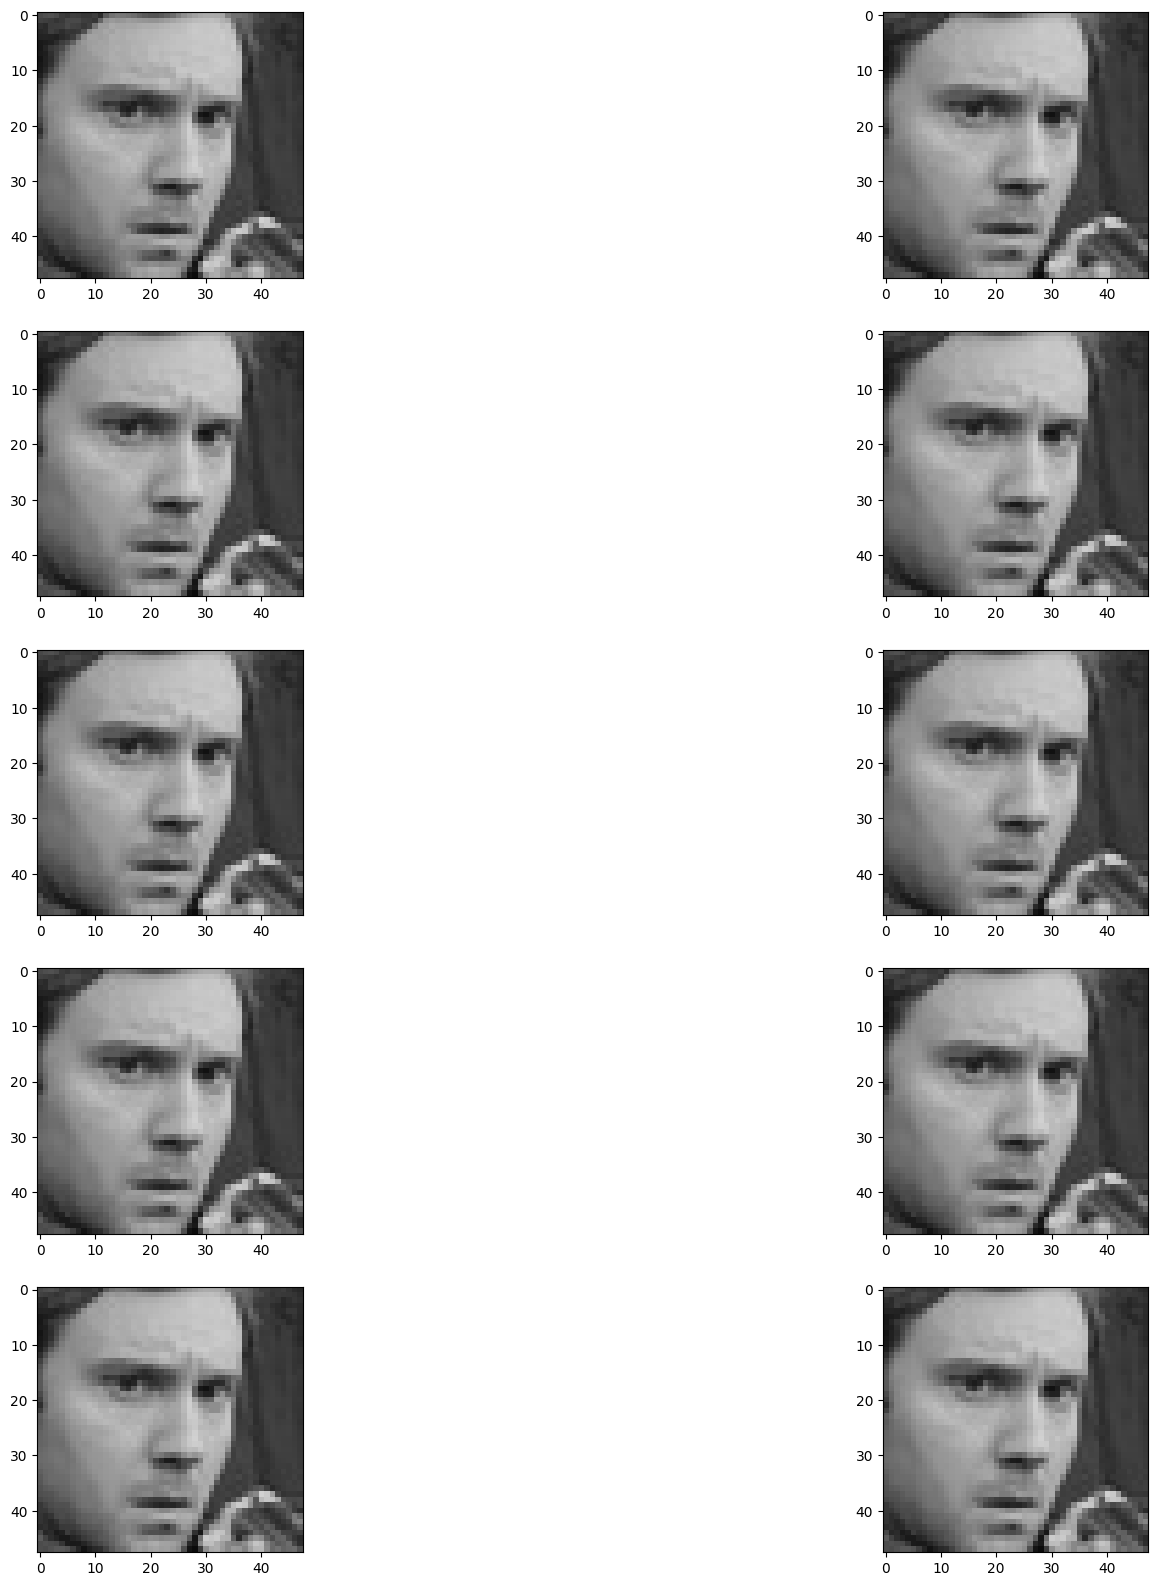

In [ ]:
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow
import cv2

print("First 10 images from Train")
print('*'*35, '\n')

fig = plt.figure(figsize=(20,20))

read = cv2.imread('/content/drive/MyDrive/hack/DATASET/images/train/angry/0.jpg')
img = cv2.cvtColor(read, cv2.COLOR_BGR2RGB)
fig.add_subplot(5,2,1)
plt.imshow(img)

for i in range(2, 11):

    fig.add_subplot(5,2,i)

    read = cv2.imread('/content/drive/MyDrive/hack/DATASET/images/train/angry/0.jpg')
    img = cv2.cvtColor(read, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

plt.show()


In [ ]:
 train_dir = "/content/drive/MyDrive/hack/DATASET/images/train"
test_dir = "/content/drive/MyDrive/hack/DATASET/images/validation"
#train_dir = "/kaggle/input/raf-db-dataset/DATASET/train"
#test_dir = "/kaggle/input/raf-db-dataset/DATASET/test"

SEED = 125
IMG_HEIGHT = 139
IMG_WIDTH = 139
BATCH_SIZE = 64
EPOCHS = 30
FINE_TUNING_EPOCHS = 20
LR = 0.01
NUM_CLASSES = 7
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
CLASS_LABELS_EMOJIS = ["👿", "🤢" , "😱" , "😊" , "😐 ", "😔" , "😲" ]

In [ ]:
preprocess_fun = tf.keras.applications.inception_v3.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 125
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True ,
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 125
                                                        )


test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 125
                                                  )

Found 23060 images belonging to 7 classes.
Found 5761 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


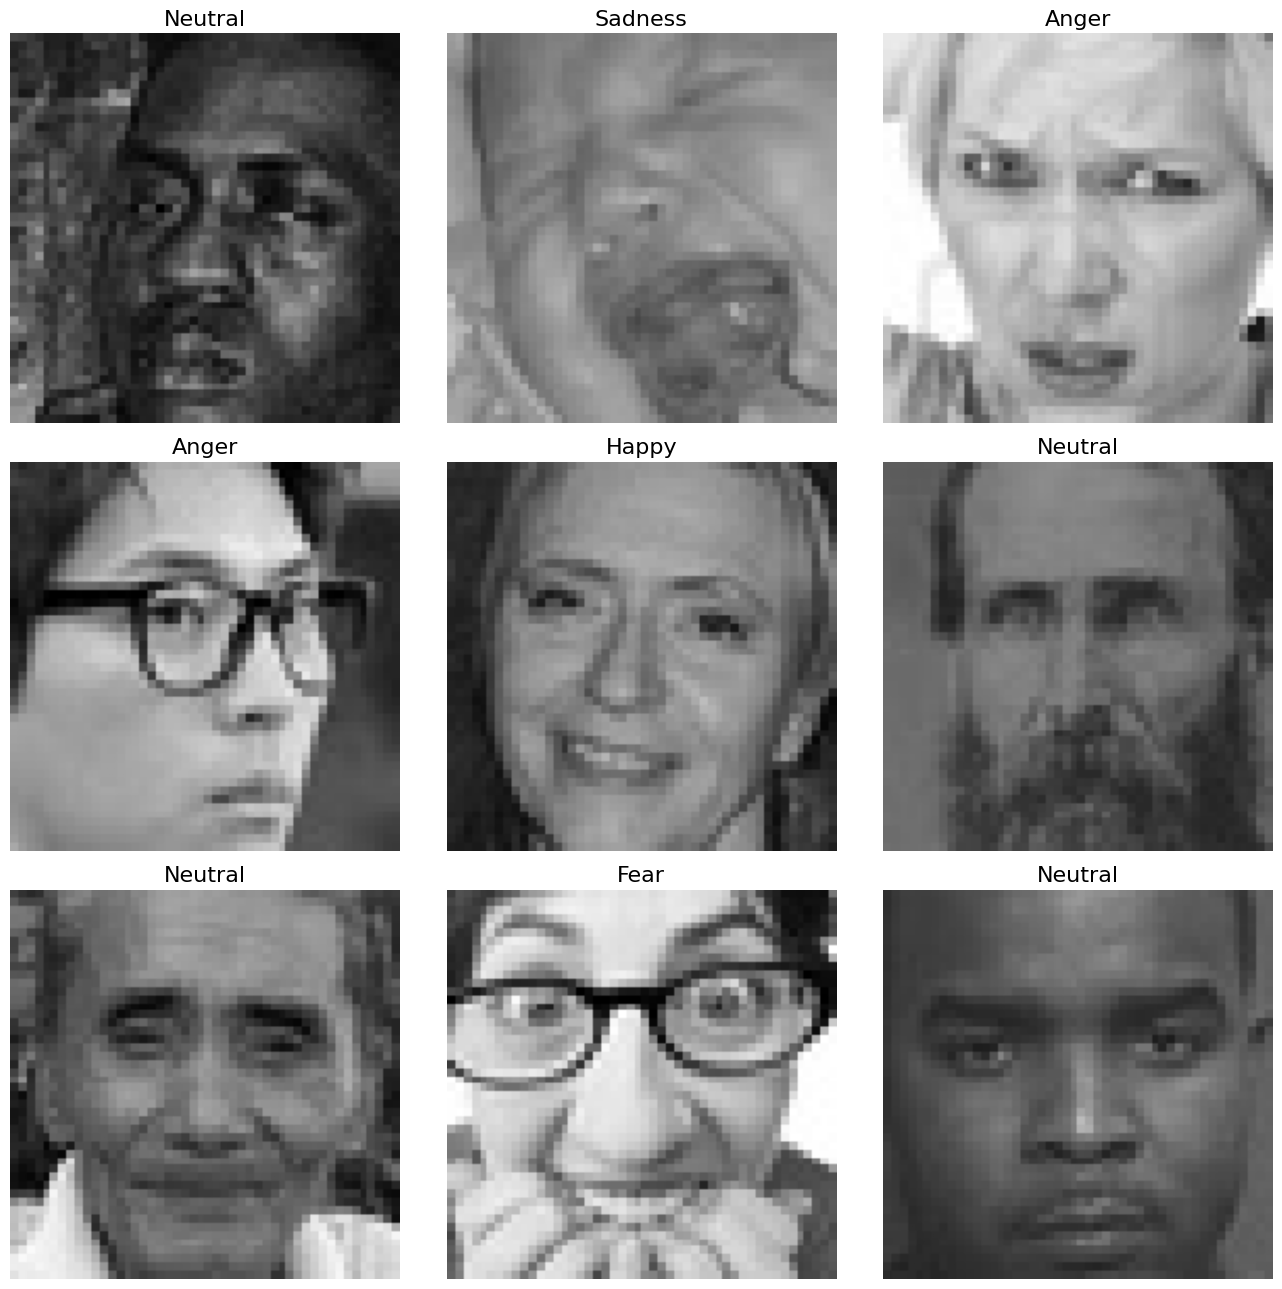

In [ ]:
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)

def display_nine_images(images, titles, title_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def image_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{CLASS_LABELS[prediction_idx]} [correct]', 'black'
    else:
        return f'{CLASS_LABELS[prediction_idx]} [incorrect, should be {CLASS_LABELS[class_idx]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(classes, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors

img_datagen = ImageDataGenerator(rescale = 1./255)
img_generator = img_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 125
                                                  )
clear_output()

images, classes = next(img_generator)
class_idxs = np.argmax(classes, axis=-1)
labels = [CLASS_LABELS[idx] for idx in class_idxs]
display_nine_images(images, labels)

In [ ]:
fig = px.bar(x = CLASS_LABELS_EMOJIS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] ,
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld")
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()


In [ ]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.InceptionV3(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)

    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    # x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    # x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    # x = tf.keras.layers.Dropout(0.5)(x)
    # x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    # x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)

    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)

    return classification_output

def define_compile_model():

    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)

    model.compile(optimizer=tf.keras.optimizers.SGD(0.1),
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

    return model

In [ ]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 139, 139, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 classification (Dense)      (None, 7)                 7175      
                                                                 
Total params: 23908135 (91.20 MB)
Trainable params: 2105351 (8.03 MB)
Non-trainable params: 21802784 (83.17 MB)
_______________

In [ ]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )
history = model.fit(x = train_generator,
                    epochs = EPOCHS ,
                    validation_data = validation_generator ,
                    callbacks= [earlyStoppingCallback])

history = pd.DataFrame(history.history)

Epoch 1/30
361/361 [==============================] - 8225s 23s/step - loss: 1.4203 - accuracy: 0.4539 - val_loss: 1.8079 - val_accuracy: 0.2689
Epoch 2/30
361/361 [==============================] - 236s 653ms/step - loss: 1.0603 - accuracy: 0.6006 - val_loss: 1.0697 - val_accuracy: 0.6034
Epoch 3/30
361/361 [==============================] - 231s 640ms/step - loss: 0.9434 - accuracy: 0.6450 - val_loss: 5.0534 - val_accuracy: 0.2619
Epoch 4/30
361/361 [==============================] - 228s 632ms/step - loss: 0.8560 - accuracy: 0.6814 - val_loss: 1.2050 - val_accuracy: 0.5780
Epoch 5/30
361/361 [==============================] - 230s 637ms/step - loss: 0.7818 - accuracy: 0.7133 - val_loss: 1.1270 - val_accuracy: 0.5850
Epoch 5: early stopping


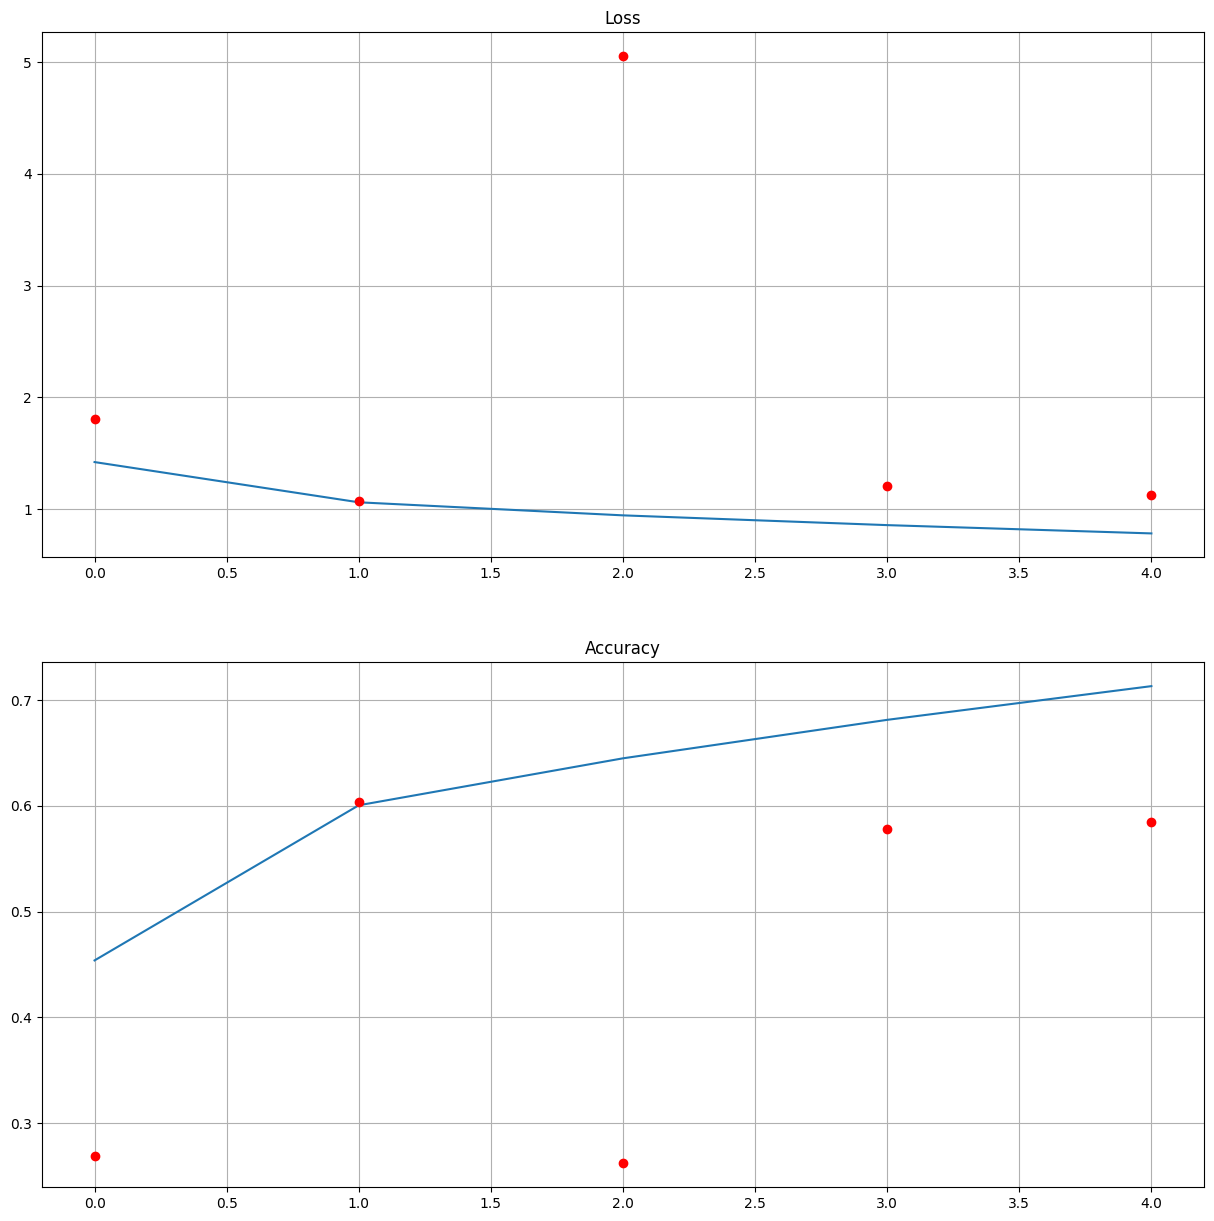

In [ ]:
# Assuming `history` is obtained from model training
history_df = pd.DataFrame(history)

# Now you can plot the data
plt.figure(figsize=(15, 15))

plt.subplot(2, 1, 1)
plt.plot(history_df['loss'])
plt.plot(history_df['val_loss'], 'ro')
plt.title('Loss')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(history_df['accuracy'])
plt.plot(history_df['val_accuracy'], 'ro')
plt.title('Accuracy')
plt.grid(True)

plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(7, activation='softmax')  # Assuming 7 output classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

test_data_dir = "/content/drive/MyDrive/hack/DATASET/images/validation"  # Example directory containing test images

# Defining test_datagen as an instance of ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1. / 255)  # You can add other preprocessing configurations here

# Redefining the test generator so it doesn't shuffle
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

true_labels = test_generator.classes
preds = model.predict(test_generator, steps=len(test_generator))
pred_labels = np.argmax(preds, axis=1)
classes = list(test_generator.class_indices.keys())


Found 7066 images belonging to 7 classes.
221/221 [==============================] - 27s 123ms/step


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization

# Define the path to your pre-trained model
model_path = '/content/drive/MyDrive/hack/DATASET/images/model.h5'

# Load the pre-trained model
model = load_model(model_path)

# Define a function to preprocess the image
def load_and_preprocess_image(image_path):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize the image to the input shape expected by the model
    img = cv2.resize(img, (48, 48))
    # Expand dimensions to create a batch dimension
    img = np.expand_dims(img, axis=-1)
    # Normalize the image pixel values
    img = img / 255.0
    return img

# Example image path
image_path = '/content/drive/MyDrive/hack/DATASET/images/images/validation/angry/10121.jpg'

# Load and preprocess the image
image = load_and_preprocess_image(image_path)

# Make predictions
predictions = model.predict(np.array([image]))

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Define your class labels
class_labels = ['angry', 'happy', 'sad', 'neutral', 'surprise', 'fear', 'disgust']

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class label
print("Predicted class:", predicted_class_label)


1/1 [==============================] - 1s 703ms/step
Predicted class: angry


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization

# Define the path to your pre-trained model
model_path = '/content/drive/MyDrive/hack/DATASET/images/model.h5'

# Load the pre-trained model
model = load_model(model_path)

# Define a function to preprocess the image
def load_and_preprocess_image(image_path):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize the image to the input shape expected by the model
    img = cv2.resize(img, (48, 48))
    # Expand dimensions to create a batch dimension
    img = np.expand_dims(img, axis=-1)
    # Normalize the image pixel values
    img = img / 255.0
    return img

# Example image path
image_path = '/content/drive/MyDrive/hack/DATASET/images/images/validation/neutral/10150.jpg'

# Load and preprocess the image
image = load_and_preprocess_image(image_path)

# Make predictions
predictions = model.predict(np.array([image]))

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Define your class labels
class_labels = ['angry', 'happy', 'sad', 'neutral', 'surprise', 'fear', 'disgust']

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class label
print("Predicted class:", predicted_class_label)


1/1 [==============================] - 1s 835ms/step
Predicted class: neutral


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization

# Define the path to your pre-trained model
model_path = '/content/drive/MyDrive/hack/DATASET/images/model.h5'

# Load the pre-trained model
model = load_model(model_path)

# Define a function to preprocess the image
def load_and_preprocess_image(image_path):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize the image to the input shape expected by the model
    img = cv2.resize(img, (48, 48))
    # Expand dimensions to create a batch dimension
    img = np.expand_dims(img, axis=-1)
    # Normalize the image pixel values
    img = img / 255.0
    return img

# Example image path
image_path = '/content/drive/MyDrive/SANIKA PHOTO.jpg'
# Load and preprocess the image
image = load_and_preprocess_image(image_path)

# Make predictions
predictions = model.predict(np.array([image]))

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Define your class labels
class_labels = ['angry', 'happy', 'sad', 'neutral', 'surprise', 'fear', 'disgust']

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class label
print("Predicted class:", predicted_class_label)


1/1 [==============================] - 0s 254ms/step
Predicted class: neutral


In [ ]:
import threading

In [ ]:
import cv2

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


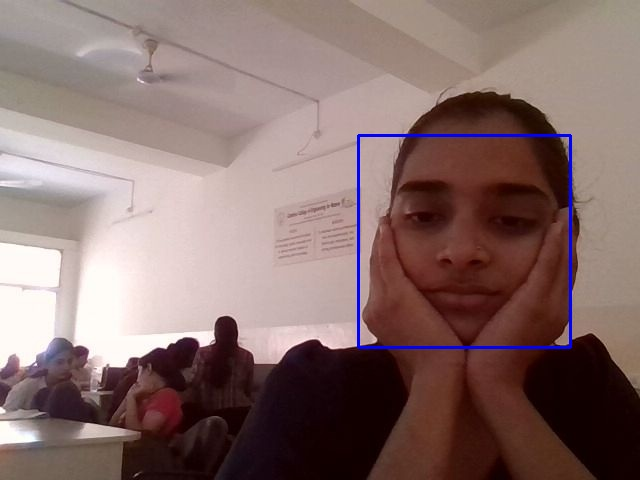

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization

# Define the path to your pre-trained model
model_path = '/content/drive/MyDrive/hack/DATASET/images/model.h5'

# Load the pre-trained model
model = load_model(model_path)

# Define a function to preprocess the image
def load_and_preprocess_image(image_path):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize the image to the input shape expected by the model
    img = cv2.resize(img, (48, 48))
    # Expand dimensions to create a batch dimension
    img = np.expand_dims(img, axis=-1)
    # Normalize the image pixel values
    img = img / 255.0
    return img

# Example image path
image_path = '/content/photo.jpg'
# Load and preprocess the image
image = load_and_preprocess_image(image_path)

# Make predictions
predictions = model.predict(np.array([image]))

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Define your class labels
class_labels = ['angry', 'happy', 'sad', 'neutral', 'surprise', 'fear', 'disgust']

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class label
print("Predicted class:", predicted_class_label)


1/1 [==============================] - 0s 262ms/step
Predicted class: sad


<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


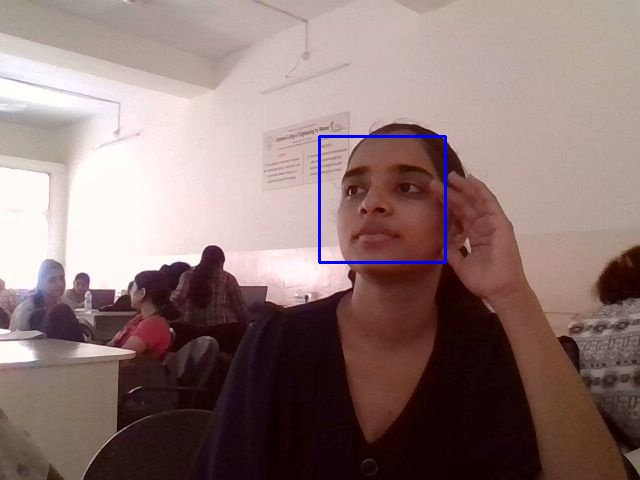

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization

# Define the path to your pre-trained model
model_path = '/content/drive/MyDrive/hack/DATASET/images/model.h5'

# Load the pre-trained model
model = load_model(model_path)

# Define a function to preprocess the image
def load_and_preprocess_image(image_path):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize the image to the input shape expected by the model
    img = cv2.resize(img, (48, 48))
    # Expand dimensions to create a batch dimension
    img = np.expand_dims(img, axis=-1)
    # Normalize the image pixel values
    img = img / 255.0
    return img

# Example image path
image_path = '/content/photo.jpg'
# Load and preprocess the image
image = load_and_preprocess_image(image_path)

# Make predictions
predictions = model.predict(np.array([image]))

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Define your class labels
class_labels = ['angry', 'happy', 'sad', 'neutral', 'surprise', 'fear', 'disgust']

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class label
print("Predicted class:", predicted_class_label)


1/1 [==============================] - 0s 267ms/step
Predicted class: disgust


<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


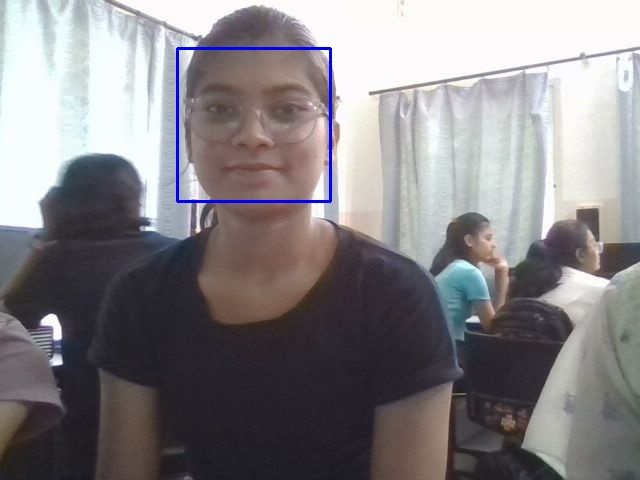

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization

# Define the path to your pre-trained model
model_path = '/content/drive/MyDrive/hack/DATASET/images/model.h5'

# Load the pre-trained model
model = load_model(model_path)

# Define a function to preprocess the image
def load_and_preprocess_image(image_path):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize the image to the input shape expected by the model
    img = cv2.resize(img, (48, 48))
    # Expand dimensions to create a batch dimension
    img = np.expand_dims(img, axis=-1)
    # Normalize the image pixel values
    img = img / 255.0
    return img

# Example image path
image_path = '/content/photo.jpg'
# Load and preprocess the image
image = load_and_preprocess_image(image_path)

# Make predictions
predictions = model.predict(np.array([image]))

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Define your class labels
class_labels = ['angry', 'happy', 'sad', 'neutral', 'surprise', 'fear', 'disgust']

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class label
print("Predicted class:", predicted_class_label)
